In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import glob
import warnings
import numpy as np
import pylab as plt

from skimage import morphology
from scipy.optimize import least_squares
from scipy.ndimage import binary_dilation

from astropy.io import fits
from astropy.time import Time
from natsort import natsorted
from astropy.stats import sigma_clip
from astropy.convolution import Gaussian2DKernel, convolve

import open3d as o3d

# Make sure we can find lassi-analysis
import sys
sys.path.append('/home/scratch/psalas/LASSI/lassi-analysis_v2')

from rotate import shiftRotateXYZ
from parabolas import loadLeicaData, fitParabola, parabola, fitLeicaData
from grid import regridXYZ, regridXYZMasked
from plotting import surfacePlot, barChartPlot, scatterPlot
from utils.utils import midPoint, radialMask, gridLimits, maskDiff
from zernikies import zernikeWLS, getZernikeCoeffs, zernikePoly, zernikeFitLS
from analyzeActiveSurface import processActiveSurfaceFITSPair
from analysis.March2020.zernike import make_aperture_efficiency, aperture_efficiency_residuals

/home/scratch/psalas/LASSI/lassi-analysis_v2/psalas_lassi_env/lib/python3.7/site-packages/dask/config.py:129: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [3]:
def costParabolaSmallAngle(coef, x, y, z):
    """
    """
    
    #xm = 50
    #ym = 100
    
    fl = coef[0]
    x0 = coef[1]
    y0 = coef[2]
    z0 = coef[3]
    rx = coef[4]
    ry = coef[5]
    
    crx = 1 - rx**2/2
    srx = rx
    cry = 1 - ry**2/2
    sry = ry
    
    xp = x*cry + y*srx*sry + z*crx*sry - x0
    yp = y*crx - z*srx - y0
    zp = -x*sry + y*srx*cry + z*crx*cry - z0
    
    xp2 = np.power(xp, 2.)
    yp2 = np.power(yp, 2.)
    
    fp = 1./(4.*fl)*(xp2 + yp2)
    
    return fp - zp

def jacParabolaSmallAngle(coef, x, y, z):
    """
    """
    
    fl = coef[0]
    x0 = coef[1]
    y0 = coef[2]
    z0 = coef[3]
    rx = coef[4]
    ry = coef[5]
    
    crx = 1 - rx**2/2
    srx = rx
    cry = 1 - ry**2/2
    sry = ry
    
    xp = x*cry + y*srx*sry + z*crx*sry - x0
    yp = y*crx - z*srx - y0
    zp = -x*sry + y*srx*cry + z*crx*cry - z0
    
    xp2 = np.power(xp, 2.)
    yp2 = np.power(yp, 2.)
    
    dxdrx = y*ry - z*rx*ry
    
    dxdry = -x*ry + y*rx + z*crx
    
    dydrx = -y*rx - z
    
    dzdrx = y*cry - z*rx*cry
    
    dzdry = -x - y*rx*ry - z*crx*ry
    
    # Jacobian columns.
    dGdfl = -1/(4*fl**2)*(xp2 + yp2)
    
    dGdx0 = -1/(4*fl)*2*xp
    
    dGdy0 = -1/(4*fl)*2*yp
    
    dGdz0 = np.ones(len(z))
    
    dGdrx = 1/(4*fl)*(2*xp*dxdrx + 2*yp*dydrx) - dzdrx
    
    dGdry = 1/(4*fl)*(2*x*dxdry) - dzdry
    
    return np.array([dGdfl, dGdx0, dGdy0, dGdz0, dGdrx, dGdry]).T


def costParabolaSmallAngleZ(coef, x, y, z):
    """
    """
    
    xm = 50
    ym = 100
    
    fl = coef[0]
    x0 = coef[1]
    y0 = coef[2]
    z0 = coef[3]
    rx = coef[4]
    ry = coef[5]
    c4 = coef[6]
    c5 = coef[7]
    c6 = coef[8]
    xc = coef[9]
    yc = coef[10]
    
    crx = 1 - rx**2/2
    srx = rx
    cry = 1 - ry**2/2
    sry = ry
    
    xp = x*cry + y*srx*sry + z*crx*sry - x0
    yp = y*crx - z*srx - y0
    zp = -x*sry + y*srx*cry + z*crx*cry - z0
    
    xh = (xp - xc)/xm
    yh = (yp - yc)/ym
    
    xp2 = np.power(xp, 2.)
    yp2 = np.power(yp, 2.)
    xh2 = np.power(xh, 2.)
    yh2 = np.power(yh, 2.)
    
    fp = 1./(4.*fl)*(xp2 + yp2)
    z4 = c4*(xh2 - yh2)
    z5 = c5*(2*xh2 + 2*yh2 - 1.)
    z6 = c6*xh*yh
    #z9 = c9*(3*xh2*yh + 3*yh2*yh - 2*yh)
    
    return fp + z4 + z5 + z6 - zp

def jacParabolaSmallAngleZ(coef, x, y, z):
    """
    """
    
    xm = 50.
    ym = 100.
    
    fl = coef[0]
    x0 = coef[1]
    y0 = coef[2]
    z0 = coef[3]
    rx = coef[4]
    ry = coef[5]
    c4 = coef[6]
    c5 = coef[7]
    c6 = coef[8]
    #c9 = coef[9]
    xc = coef[9]
    yc = coef[10]
    
    crx = 1. - rx**2./2.
    srx = rx
    cry = 1. - ry**2./2.
    sry = ry
    
    xp = x*cry + y*srx*sry + z*crx*sry - x0
    yp = y*crx - z*srx - y0
    zp = -x*sry + y*srx*cry + z*crx*cry - z0
    
    dxdrx = y*ry - z*rx*ry
    
    dxdry = -x*ry + y*rx + z*crx
    
    dydrx = -y*rx - z
    
    dzdrx = y*cry - z*rx*cry
    
    dzdry = -x - y*rx*ry - z*crx*ry
    
    xh = (xp - xc)/xm
    yh = (yp - yc)/ym
    
    xp2 = np.power(xp, 2.)
    yp2 = np.power(yp, 2.)
    xh2 = np.power(xh, 2.)
    yh2 = np.power(yh, 2.)
    
    dxhdx = -1./xm # Same for dxh/dxc or dxh/dx0
    dyhdy = -1./ym # Same for dyh/dyc or dyh/dy0
    
    dxhdrx = dxhdx*dxdrx
    
    dxhdry = dxhdx*dxdry
    
    dyhdrx = dyhdy*dydrx
    
    dyhdry = 0.
    
    dGdfl = -1./(4.*fl**2.)*(xp2 + yp2)
    
    dGdx0 = -1./(4.*fl)*2.*xp + c4*2.*xh*dxhdx + c5*4*xh*dxhdx + c6*yh*dxhdx #+ c9*6*xh*yh*dxhdx
    
    dGdy0 = -1./(4.*fl)*2.*yp - c4*2.*yh*dyhdy + c5*4*yh*dyhdy + c6*xh*dyhdy #+ c9*(3*xh2 + 9*yh2 - 2)*dyhdy
    
    dGdz0 = np.ones(len(z))
    
    dGdrx = 1./(4.*fl)*(2.*xp*dxdrx + 2.*yp*dydrx) + c4*(2.*xh*dxhdrx - 2.*yh*dyhdrx) + \
            c5*(4*xh*dxhdrx + 4*yh*dyhdrx) \
            + c6*(yh*dxhdrx + xh*dyhdrx) #+ c9*(6*xh*yh*dxhdrx + 3*xh*dyhdrx + 9*yh2*dyhdrx - 2*dyhdrx) - dzdrx
    
    dGdry = 1./(4.*fl)*(2.*x*dxdry) + c4*2.*xh*dxhdry + c5*4*xh*dxhdry #+ c6*yh*dxhdry + c9*6*xh*yh*dxhdry - dzdry
    
    dGdc4 = (xh2 - yh2)
    
    dGdc5 = 2.*xh2 + 2.*yh2 - 1.
    
    dGdc6 = xh*yh
    
    #dGdc9 = 3.*xh2*yh + 3.*yh2*yh - 2.*yh
    
    dGdxc = c4*2.*xh*dxhdx + c5*4.*xh*dxhdx + c6*yh*dxhdx #+ c9*6*xh*yh*dxhdx
    
    dGdyc = -c4*2.*yh*dyhdy + c5*4*yh*dyhdy + c6*xh*dyhdy #+ c9*(3*xh2*dyhdy + 9*yh2*dyhdy - 2*dyhdy)
    
    return np.array([dGdfl, dGdx0, dGdy0, dGdz0, dGdrx, dGdry, dGdc4, dGdc5, dGdc6, dGdxc, dGdyc]).T # dGdc9, dGdxc, dGdyc]).T


def costParabola(coef, x, y, z):
    """
    """
    
    #xm = 50
    #ym = 100
    
    fl = coef[0]
    x0 = coef[1]
    y0 = coef[2]
    z0 = coef[3]
    rx = coef[4]
    ry = coef[5]
    
    crx = np.cos(rx)
    srx = np.sin(rx)
    cry = np.cos(ry)
    sry = np.sin(ry)
    
    xp = x*cry + y*srx*sry + z*crx*sry - x0
    yp = y*crx - z*srx - y0
    zp = -x*sry + y*srx*cry + z*crx*cry - z0
    
    xp2 = np.power(xp, 2.)
    yp2 = np.power(yp, 2.)
    
    fp = 1./(4.*fl)*(xp2 + yp2)
    
    return fp - zp


def jacParabola(coef, x, y, z):
    """
    """
    
    fl = coef[0]
    x0 = coef[1]
    y0 = coef[2]
    z0 = coef[3]
    rx = coef[4]
    ry = coef[5]
    
    crx = np.cos(rx)
    srx = np.sin(rx)
    cry = np.cos(ry)
    sry = np.sin(ry)
    
    xp = x*cry + y*srx*sry + z*crx*sry - x0
    yp = y*crx - z*srx - y0
    zp = -x*sry + y*srx*cry + z*crx*cry - z0
    
    xp2 = np.power(xp, 2.)
    yp2 = np.power(yp, 2.)
    
    dxdrx = y*crx*sry - z*srx*sry
    
    dxdry = -x*sry + y*srx*cry + z*crx*cry
    
    dydrx = -y*srx - z*crx
    
    dzdrx = y*crx*cry - z*srx*cry
    
    dzdry = -x*cry - y*srx*sry - z*crx*sry
    
    # Jacobian columns.
    dGdfl = -1/(4*fl**2)*(xp2 + yp2)
    
    dGdx0 = -1/(4*fl)*2*xp
    
    dGdy0 = -1/(4*fl)*2*yp
    
    dGdz0 = np.ones(len(z))
    
    dGdrx = 1/(4*fl)*(2*xp*dxdrx + 2*yp*dydrx) - dzdrx
    
    dGdry = 1/(4*fl)*(2*x*dxdry) - dzdry
    
    return np.array([dGdfl, dGdx0, dGdy0, dGdz0, dGdrx, dGdry]).T


def costParabolaZ(coef, x, y, z):
    """
    """
    
    xm = 50
    ym = 100
    
    fl = coef[0]
    x0 = coef[1]
    y0 = coef[2]
    z0 = coef[3]
    rx = coef[4]
    ry = coef[5]
    c4 = coef[6]
    c5 = coef[7]
    c6 = coef[8]
    #c9 = coef[9]
    xc = coef[9]
    yc = coef[10]
    
    crx = np.cos(rx)
    srx = np.sin(rx)
    cry = np.cos(ry)
    sry = np.sin(ry)
    
    xp = x*cry + y*srx*sry + z*crx*sry - x0
    yp = y*crx - z*srx - y0
    zp = -x*sry + y*srx*cry + z*crx*cry - z0
    
    xh = (xp - xc)/xm
    yh = (yp - yc)/ym
    
    xp2 = np.power(xp, 2.)
    yp2 = np.power(yp, 2.)
    xh2 = np.power(xh, 2.)
    yh2 = np.power(yh, 2.)
    
    fp = 1/(4*fl)*(xp2 + yp2)
    z4 = c4*(xh2 - yh2)
    z5 = c5*(2*xh2 + 2*yh2 - 1.)
    z6 = c6*xh*yh
    #z9 = c9*(3*xh2*yh + 3*yh2*yh - 2*yh)
    
    return fp + z4 + z5 + z6 - zp


def jacParabolaZ(coef, x, y, z):
    """
    """
    
    xm = 50.
    ym = 100.
    
    fl = coef[0]
    x0 = coef[1]
    y0 = coef[2]
    z0 = coef[3]
    rx = coef[4]
    ry = coef[5]
    c4 = coef[6]
    c5 = coef[7]
    c6 = coef[8]
    #c9 = coef[9]
    xc = coef[9]
    yc = coef[10]
    
    crx = np.cos(rx)
    srx = np.sin(rx)
    cry = np.cos(ry)
    sry = np.sin(ry)
    
    xp = x*cry + y*srx*sry + z*crx*sry - x0
    yp = y*crx - z*srx - y0
    zp = -x*sry + y*srx*cry + z*crx*cry - z0
    
    dxdrx = y*crx*sry - z*srx*sry
    
    dxdry = -x*sry + y*srx*cry + z*crx*cry
    
    dydrx = -y*srx - z*crx
    
    dzdrx = y*crx*cry - z*srx*cry
    
    dzdry = -x*cry - y*srx*sry - z*crx*sry
    
    xh = (xp - xc)/xm
    yh = (yp - yc)/ym
    
    xp2 = np.power(xp, 2.)
    yp2 = np.power(yp, 2.)
    xh2 = np.power(xh, 2.)
    yh2 = np.power(yh, 2.)
    
    dxhdx = -1./xm # Same for dxh/dxc or dxh/dx0
    dyhdy = -1./ym # Same for dyh/dyc or dyh/dy0
    
    dxhdrx = dxhdx*dxdrx
    
    dxhdry = dxhdx*dxdry
    
    dyhdrx = dyhdy*dydrx
    
    dyhdry = 0
    
    dGdfl = -1./(4.*fl**2.)*(xp2 + yp2)
    
    dGdx0 = -1./(4.*fl)*2.*xp + c4*2.*xh*dxhdx + c5*4.*xh*dxhdx + c6*yh*dxhdx #+ c9*6.*xh*yh*dxhdx
    
    dGdy0 = -1./(4.*fl)*2.*yp - c4*2.*yh*dyhdy + c5*4.*yh*dyhdy + c6*xh*dyhdy #+ c9*(3.*xh2 + 9.*yh2 - 2.)*dyhdy
    
    dGdz0 = np.ones(len(z))
    
    dGdrx = 1./(4.*fl)*(2.*xp*dxdrx + 2.*yp*dydrx) + c4*(2.*xh*dxhdrx - 2.*yh*dyhdrx) + \
            c5*(4.*xh*dxhdrx + 4.*yh*dyhdrx) \
            + c6*(yh*dxhdrx + xh*dyhdrx) - dzdrx #+ c9*(6.*xh*yh*dxhdrx + 3.*xh*dyhdrx + 9.*yh2*dyhdrx - 2.*dyhdrx) - dzdrx
    
    dGdry = 1./(4.*fl)*(2.*x*dxdry) + c4*2.*xh*dxhdry + c5*4.*xh*dxhdry + c6*yh*dxhdry - dzdry #+ c9*6.*xh*yh*dxhdry - dzdry
    
    dGdc4 = (xh2 - yh2)
    
    dGdc5 = 2*xh2 + 2*yh2 - 1
    
    dGdc6 = xh*yh
    
    #dGdc9 = 3*xh2*yh + 3*yh2*yh - 2*yh
    
    dGdxc = c4*2.*xh*dxhdx + c5*4.*xh*dxhdx + c6*yh*dxhdx #+ c9*6.*xh*yh*dxhdx
    
    dGdyc = -c4*2.*yh*dyhdy + c5*4.*yh*dyhdy + c6*xh*dyhdy #+ c9*(3.*xh2*dyhdy + 9.*yh2*dyhdy - 2.*dyhdy)
    
    return np.array([dGdfl, dGdx0, dGdy0, dGdz0, dGdrx, dGdry, dGdc4, dGdc5, dGdc6, dGdxc, dGdyc]).T

def parabolaFit(x, y, z, guess, method=costParabola, jac=jacParabola, 
                bounds=None,  max_nfev=10000, ftol=1e-12, xtol=1e-12, gtol=1e-12, 
                loss="soft_l1", f_scale=1e-5, tr_solver=None, x_scale=None, verbose=False):
    
    # Set boundaries for the fit parameters.
    if bounds is None:
        inf = np.inf
        pi2 = 2*np.pi
        omin = -10
        omax = 10
        cmin = -1e0
        cmax = 1e0
        if len(guess) == 11:
            b1 = [59, omin, omin, -55, -pi2, -pi2, cmin, cmin, cmin, -2, 45]
            b2 = [61, omax, omax, -45,  pi2,  pi2, cmax, cmax, cmax,  2, 55]
        else:
            b1 = [59, -inf, -inf, -inf, -pi2, -pi2]
            b2 = [61,  inf,  inf,  inf,  pi2,  pi2]
            
        bounds = (b1, b2)
    
    if verbose:
        print(bounds)
    
    if x_scale is None:
        xsr = np.deg2rad(0.001)
        xsz = 5e-5
        xso = 0.2
        if len(guess) == 11:
            x_scale = [1e-3, xso, xso, xso, xsr, xsr, xsz, xsz, xsz, xso/50., xso/100.]
        else:
            x_scale = [1e-3, xso, xso, xso, xsr, xsr]
    
    if jac == None:
        jac = "3-point"
    
    args = (x.flatten(), y.flatten(), z.flatten())
    
    r = least_squares(method, guess, jac,
                      args=args,
                      bounds=bounds,
                      max_nfev=max_nfev,
                      loss=loss,
                      f_scale=f_scale,
                      ftol=ftol,
                      xtol=xtol,
                      gtol=gtol,
                      x_scale=x_scale,
                      tr_solver=tr_solver)
    return r

def removeParabolaFit(x, y, z, fit):
    cor = np.hstack((-1*fit[1:4],fit[4:6],0))
    xgdr, ygdr, zgdr = shiftRotateXYZ(x, y, z, cor)
    zp = parabola(xgdr, ygdr, fit[0])
    diff = zgdr - zp
    return diff

In [4]:
def parabolaFitIterations(x, y, z, guess=[60., 0, 0, -50., 0, 0], bounds=None, iters=2, jac='2-point',
                          max_nfev=10000, ftol=1e-12, xtol=1e-15, f_scale=1e-4, verbose=False):
    
    mask = np.isnan(z)
    
    for i in range(iters):
        
        if verbose:
            print("Iteration: {}".format(i))
        
        x_ = np.ma.masked_where(mask, x)
        y_ = np.ma.masked_where(mask, y)
        z_ = np.ma.masked_where(mask, z)
        
        fit = parabolaFit(x_.compressed(), y_.compressed(), z_.compressed(), 
                          guess,
                          method=costParabolaZ, jac=jac, tr_solver=None,
                          bounds=bounds, max_nfev=max_nfev, ftol=ftol, xtol=xtol, 
                          f_scale=f_scale, verbose=verbose)
        
        xdr, ydr, zdr = alignXYZ(x, y, z, fit.x)
        
        zp = parabola(xdr, ydr, fit.x[0])
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            res = sigma_clip(zdr - zp)
        mask = binary_dilation(res.mask, iterations=2)
        guess = fit.x
    
    return fit, mask

def prepareData(filename, n=512, rot=178.):
    orgData, cleanData = loadLeicaData(filename, n=None, numpy=False)
    x = orgData[0]
    y = orgData[1]
    z = orgData[2]
    xg, yg, zg = regridXYZ(x, y, z, n=n)
    xg, yg, zg = shiftRotateXYZ(xg, yg, zg, [0, 0, 0, 0, 0, np.deg2rad(rot)])
    
    return xg, yg, zg

def maskLoop(diff, window=(20,20), threshold=2):
    mask = maskDiff(diff, window=window, threshold=threshold)
    mDiff = np.ma.masked_where(mask, diff)
    b = morphology.remove_small_holes(mDiff.mask, area_threshold=64)
    mDiff = np.ma.masked_where(b, mDiff)
    return mDiff

def maskData(diff, window=(20,20), threshold=2):
    mDiff = maskLoop(diff, window=window, threshold=threshold)
    #mDiff = np.ma.masked_outside(mDiff, -5e-3, 5e-3)
    mDiff = maskLoop(diff, window=window, threshold=threshold)
    return mDiff

def alignXYZ(x, y, z, fit):
    cor = np.hstack((-1*fit[1:4],fit[4:6],0))
    xr, yr, zr = shiftRotateXYZ(x, y, z, cor)
    return xr, yr, zr

In [5]:
n = 512
rot = 179.5
iters = 6
f_scale = 1e-2
guess = [6.00319194e+01, 2.464, -0.914, -4.92e+01, 2.19754536e-01, 5.02049715e-04]
guess = [6.00319194e+01, 2.45282692e+00, -9.96895755e-01, -4.92e+01, 2.19838173e-01, -5.05770158e-03]
guess = [6.0e+01, 0, 0, -49, 0, 0]
kernel = Gaussian2DKernel(x_stddev=17.)
nZern = 36
maskIters = 3
iz = 4
izv = -518
zcoef = np.zeros(nZern)
zcoef[iz] = izv
scanDir = '/home/scratch/psalas/LASSI/gpus/output/'

In [6]:
%%time
refScan = "{0}/2020_03_16_ref_average.ptx.csv".format(scanDir)
#refScan = "{0}/2020_03_16_02:54:59.ptx.csv".format(scanDir)
#refScan = "{0}/2020_03_16_06:11:20.ptx.csv".format(scanDir)
xr, yr, zr = prepareData(refScan, n=n, rot=rot)

CPU times: user 8.35 s, sys: 1.82 s, total: 10.2 s
Wall time: 7.19 s


In [7]:
%%time
sigScan = "{0}/2020_03_16_02:28:31.ptx.csv".format(scanDir) # C4=-518
#sigScan = "{0}/2020_03_16_03:02:51.ptx.csv".format(scanDir) # C4=-486
#sigScan = "{0}/2020_03_16_03:27:25.ptx.csv".format(scanDir) # C4=-167
#sigScan = "{0}/2020_03_16_03:52:01.ptx.csv".format(scanDir) # C4=-75
#sigScan = "{0}/2020_03_16_06:43:17.ptx.csv".format(scanDir) # C4=-562
#sigScan = "{0}/2020_03_16_07:32:07.ptx.csv".format(scanDir) # C4=-75
#sigScan = "{0}/2020_03_16_02:21:06.ptx.csv".format(scanDir) # Ref scan
#sigScan = "{0}/2020_03_16_07:56:13.ptx.csv".format(scanDir) # C7=-554
#sigScan = "{0}/2020_03_16_05:30:05.ptx.csv".format(scanDir) # C13=-534
xs, ys, zs = prepareData(sigScan, n=n, rot=rot)

CPU times: user 4.6 s, sys: 1.11 s, total: 5.71 s
Wall time: 3.68 s


In [8]:
inf = np.inf
pi2 = 2*np.pi
b1 = [59., -inf, -inf, -49.2-1e-4, -pi2, -pi2]
b2 = [61.,  inf,  inf, -49.2+1e-4,  pi2,  pi2]
bounds = (b1, b2)
bounds = None

%%time
zrFit = parabolaFit(xr[~np.isnan(zr)], yr[~np.isnan(zr)], zr[~np.isnan(zr)], 
                  guess+[0, 0, 0, 0, 0, 50],
                  method=costParabolaZ, jac=jacParabolaZ, tr_solver=None,
                  bounds=None, max_nfev=100000, ftol=1e-12, xtol=1e-12, verbose=False)

In [9]:
%%time
#zrs = convolve(zr, kernel, boundary='extend', fill_value=0.0, nan_treatment='interpolate', 
#                normalize_kernel=True, mask=None, preserve_nan=True, normalization_zero_tol=1e-08)
zrFiti, zrMask = parabolaFitIterations(xr[~np.isnan(zr)], yr[~np.isnan(zr)], zr[~np.isnan(zr)], 
                                       guess=guess+[0, 0, 0, 0, 50], iters=iters, jac=jacParabolaZ,
                                       bounds=None, max_nfev=100000, ftol=1e-12, xtol=1e-15, f_scale=f_scale)

CPU times: user 1min 29s, sys: 1min 11s, total: 2min 40s
Wall time: 12.2 s


%%time
zsFit = parabolaFit(xs[~np.isnan(zs)], ys[~np.isnan(zs)], zs[~np.isnan(zs)], 
                  guess+[0, 0, 0, 0, 0, 50],
                  method=costParabolaZ, jac=jacParabolaZ, tr_solver=None,
                  bounds=None, max_nfev=100000, ftol=1e-12, xtol=1e-12, verbose=False)

In [10]:
%%time
#zss = convolve(zs, kernel, boundary='extend', fill_value=0.0, nan_treatment='interpolate', 
#                normalize_kernel=True, mask=None, preserve_nan=True, normalization_zero_tol=1e-08)
zsFiti, zsMask = parabolaFitIterations(xs[~np.isnan(zs)], ys[~np.isnan(zs)], zs[~np.isnan(zs)], 
                                       guess=guess+[0, 0, 0, 0, 50], iters=iters, jac=jacParabolaZ,
                                       bounds=None, max_nfev=100000, ftol=1e-12, xtol=1e-15, f_scale=f_scale)

CPU times: user 1min 22s, sys: 1min 4s, total: 2min 27s
Wall time: 10.9 s


In [11]:
#print(zrFit.x)
print(zrFiti.x)
#print(zsFit.x)
print(zsFiti.x)

[ 5.99303730e+01  2.47423340e+00 -6.40108115e-01 -4.93099262e+01
  2.18015984e-01  6.16576909e-04  7.30949039e-02 -4.88626963e-02
  1.09424471e-03 -1.80786262e-01  5.09035761e+01]
[ 6.01031534e+01  2.46378743e+00 -7.68828832e-01 -4.93035239e+01
  2.17866128e-01  5.12349738e-04  3.02228262e-02 -1.32914037e-02
  3.74022868e-03  3.53451566e-01  5.05588888e+01]


In [12]:
pFitR = np.copy(zrFiti.x)
pFitS = np.copy(zrFiti.x)
xra, yra, zra = alignXYZ(xr, yr, zr, pFitR)
xsa, ysa, zsa = alignXYZ(xs, ys, zs, pFitS)

In [13]:
%%time
xmin, xmax = gridLimits(xsa, xra)
ymin, ymax = gridLimits(ysa, yra)
xrag, yrag, zrag = regridXYZ(xra, yra, zra, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
xsag, ysag, zsag = regridXYZ(xsa, ysa, zsa, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

CPU times: user 20 s, sys: 2.73 s, total: 22.7 s
Wall time: 17.2 s


/home/scratch/psalas/LASSI/lassi-analysis_v2/utils/utils.py:131: RuntimeWarning: invalid value encountered in greater
  mask = (np.ma.abs(diff - diff_avg)/diff_rms > threshold) | (diff_rms == 0)
/home/scratch/psalas/LASSI/lassi-analysis_v2/utils/utils.py:131: RuntimeWarning: invalid value encountered in greater
  mask = (np.ma.abs(diff - diff_avg)/diff_rms > threshold) | (diff_rms == 0)


<IPython.core.display.Javascript object>


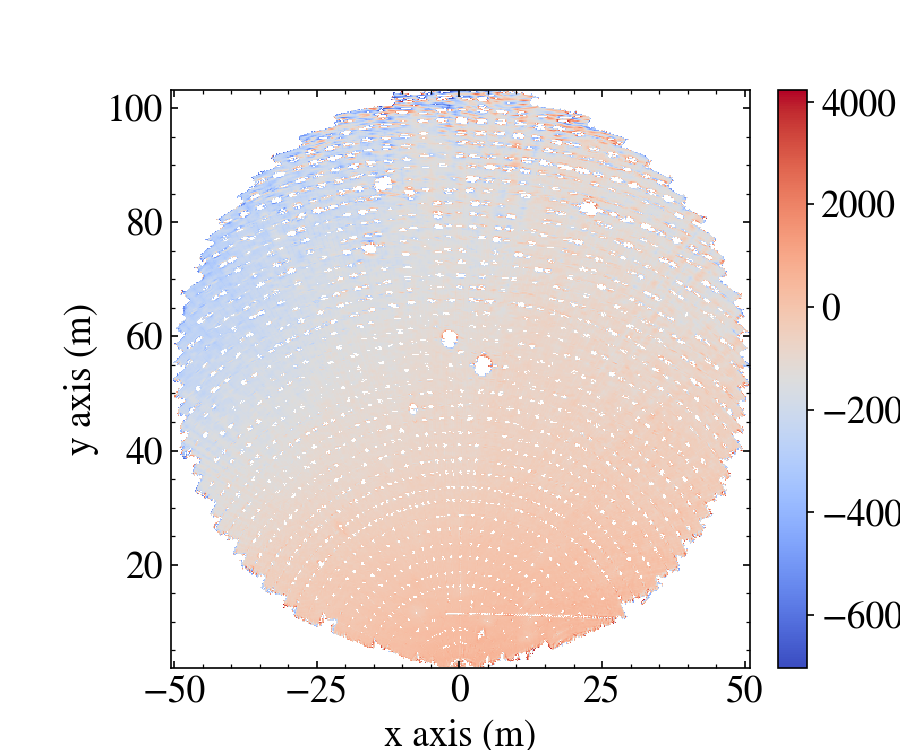

In [17]:
diff = np.ma.masked_invalid(zsag - zrag)
#diff = np.ma.masked_outside(diff, -7e-3, 7e-3)
diff = sigma_clip(diff, 5)
diff = maskData(diff)
vmin = np.nanmin(diff*1e6)
vmax = np.nanmax(diff*1e6)
surfacePlot(xrag, yrag, diff.T*1e6, vMin=vmin, vMax=vmax, midPoint=(vmin+vmax)*0.5)

<IPython.core.display.Javascript object>


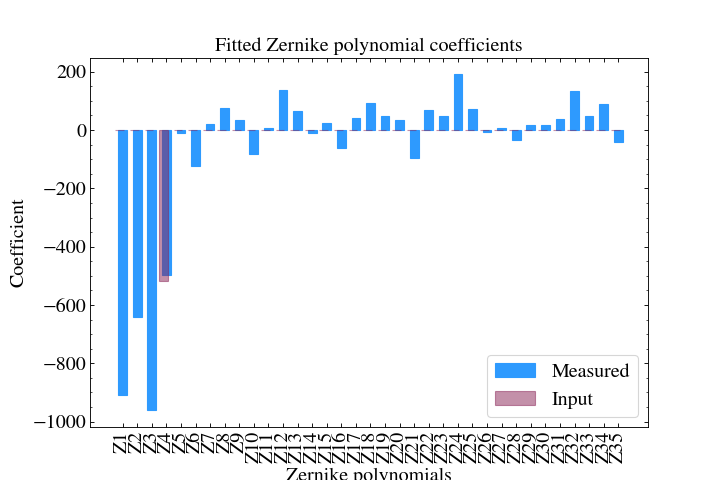

-497.6733779475774


In [18]:
fl_fs = getZernikeCoeffs(diff.filled(0)[::-1].T, 36, norm='active-surface')
barChartPlot(np.arange(1,36), fl_fs[1:36]*1e6, expected=zcoef[1:36])
print(fl_fs[iz]*1e6)

Number of iterations: 2


<IPython.core.display.Javascript object>


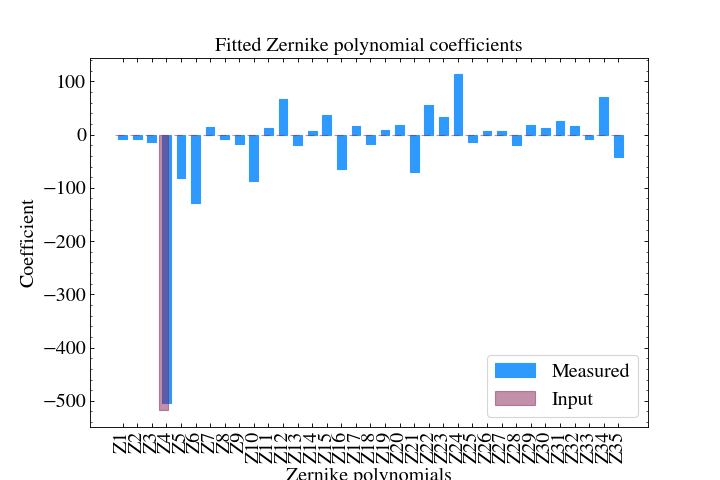

-503.73569305462706


<IPython.core.display.Javascript object>


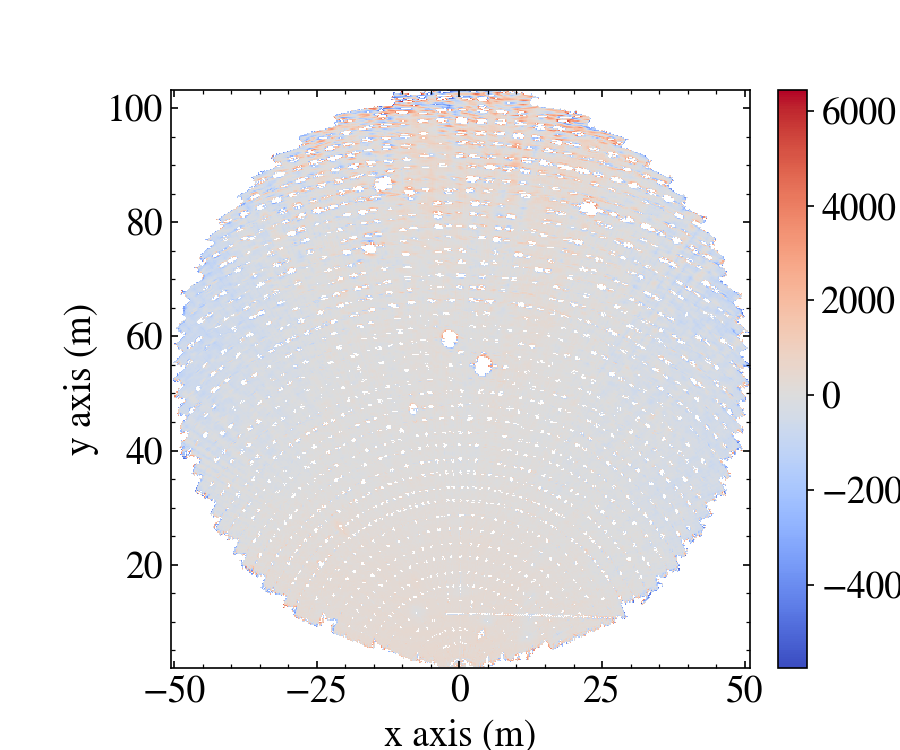

In [19]:
diff_ = np.ma.copy(diff)
fl_fs_sub = np.copy(fl_fs)
it = 0
while np.any(abs(fl_fs_sub[2:4]) > 100e-6):
    #fl_fs_sub[1] *= 0.
    fl_fs_sub[2] *= -1.
    zpoly_ = zernikePoly(xrag, yrag, midPoint(xrag), midPoint(yrag), fl_fs_sub[0:4])
    diff_ = diff_ - zpoly_
    fl_fs_sub = getZernikeCoeffs(diff_.filled(0)[::-1].T, 36, norm='active-surface')
    it += 1
print("Number of iterations: {}".format(it))
barChartPlot(np.arange(1,36), fl_fs_sub[1:36]*1e6, expected=zcoef[1:36])
print(fl_fs_sub[iz]*1e6)
surfacePlot(xrag, yrag, diff_.T*1e6, vMin=np.nanmin(diff_*1e6), vMax=np.nanmax(diff_*1e6))